CS524: Introduction to Optimization Final Project
====================================================

## Fleet Assignment <br><span style="color:red"> University of Wisconsin-Madison

<span style="color:blue">**Neel Kelkar, Siddharth Mohan**</span>

## Dec 16 , 2019
--------------
In this project we discuss the following topics:
* The fleet assignment problem.
* Modeling the fleet assignment problem as a time-space network.
* The variables, parameters, and the equations needed to solve this problem in GAMS.
* Generating data for this problem.
* Entending the problem to incorporate connecting flights.


# Fleet Assignment Problem

The Airlines industry is a very competitive market. An aircraft seat is considered to be one of the most perishable commodities in the world. Every time an aircraft takes off with an empty seat, there is revenue lost. Each Airline tries to maximize its profits and tries to find the best schedules in order to achieve the same. However, this decision marking is very complex due to the large size of the problem (many airports and many routes). It involves servicing multiple airports each with its own set of restrictions, running different aircraft types with different operational costs, and scheduling the crew based on their requirements and regulations.

In this project we deal with one such Airline operational problem - the fleet assignment problem. An airline has several flight legs every day which is done using aircrafts from different fleets. The fleet assignment problem is to assign fleets (aircrafts) to the airline schedule (flight legs) so that seats are filled with paying passengers.. Both the size of the fleets and the different types of aircraft have a big impact on the scheduling. The trade-off here is the operational cost of a fleet vs the capacity or demand of the passengers at that time. If the airline uses a small plane it can take less passengers and incurs a small operational cost, while if it uses a large fleet, it can take many passengers (more revenue) but also incurs a higher operational cost. In order to maximize the profit, the goal would be to choose the right assignment of fleet, i.e. to have the right fleet in the right airport at the right time. Constraints related to time, the availability of the fleet, and how they can possibly operate makes this an interesting and non-trivial problem.

We have used the paper “Coldstart: Fleet Assignment at Delta Air Lines.” for references and definitions.

**An example of the (data) is:**

> Fleet legs (flight schedule)

| Flight Num     | From | To     | Dep. Time | Arrival Time | Fase ($) | Demand (Passengers) |
| :---        |    :----:   |  :----:   |:----:   |:----:   |:----:   |        ---: |
    | F1     | Madison       | Chicago   | 11:00 | 12:15 | 120 | 200 |
    | F2 | Madison | Boston | 11:30 | 13:00 | 180 | 150 |
    | F3 | Chicago | SFO | 15:00 | 19:00 | 220 | 250 |
    
> Fleet Composition

| Fleet Type     | Number owned | Capacity     |
| :---       |:----:   |       ---: |
| f1 | 1 | 100 |
| f2 | 3 | 150 |
    
> Operating costs of fleet (per flight)

| Fleet Type     | Flight Num | Operating costs (000$)     |
| ----------- | ----------- | ------------- |
| f1 | F1 | 10 |
| f1 | F2 | 12 |
| f1 | F3 | 20 |
| f2 | F1 | 17 |
| f2 | F2 | 15 |
| f2 | F3 | 12 |

**Assumptions:**
* The flight schedule happens every day.
* We need to assign one fleet to every flight leg. No flights in the data can be dropped.
* There are only direct flights between airports.
* Passengers can be lost and the airlines doesn't need to serive all passengers if it is not benefial to it (by adding more flights). The airlines loses passengers to its competitors.
* The airlines does not fly more than one flight between two airports at the same time.
* The data generated for the flight schedule is correct and there exists a solution.
      

# Modelling

The fleet assignment model can be modelled as a time-space network. A node in this network is indexed over (airport, time). If the number of different possible times in the flight schedule is 24 (assume flights start and end in multiple of 1 hour intervals), then the total number of nodes for airport A is 24. Edges in a time space network indicate are called arcs. There are two types of arcs here:

* **Sky arcs**: A connection from the node from one (airport1, time1) to another (airport2,, time2) indicates that airport1 and airport2 are connected between time1 and time2. The skyarcs is formed using the flight schedule provided. 
* **Ground arcs**: These are arcs between nodes for the same airport. This is used to indicate the number of aircraft of a type of fleet docked at the airport between time intervals. The ground arcs are connected between t and t+1. There is also a ground arc connecting the last node to the first node at every airport, indicating a 24 hour period.



<img src="time-space.png" style="width:700px;height:500px;">

# The Model

<span style="color:red">The fleet assignment problem is a mixed integer network flow problem.</span>
>**Constraints:**
* Not more than the available number of aircraft in each fleet can be used.
* Fleet balance at every airport - If you fly in X aircraft from A to B, then airport B only has X. You cannot fly out from B to C with aircraft Y.

**Sets**
* airport.
* time - The different times at which a flight either arrives or departs.
* fleet - The different aircraft fleet.
* skyarcs$_{airport, time, airport, time}$ - Indicates a flight leg.
* groundarcs$_{airport, time, airport, time}$ - Indicates that aircrafts can be docked at an airport between two times.

**Parameters**
* demand$_{airport, time, airport, time}$ - Indicates the demand for a flight leg.
* fare$_{airport, time, airport, time}$ - Indicates the fare for a flight leg.
* capacity$_{fleet}$ - Capacity of a fleet.
* num$_{fleet}$ - Number of aircraft available in a fleet.
* opcost$_{fleet, airport, airport}$ - Operation cost incurred to fly aircraft from fleet between two airports.
* cost$_{fleet, airport, time, airport, time}$ - Cost of assigning fleet to the given flight leg.

$$cost_{fleet, airport, time, airport, time} = min(demand_{airport, time, airport, time}, capacity_{fleet})*fare_{airport, time, airport, time} - opcost_{fleet, airport, airport}$$
<br/>

**Decision Variables** <br/>
>$f_{fleet, airport, time, airport, time} = 1$ if fleet is assigned to the flight leg, 0 otherwise <br/>
$groundFlights_{fleet, airport, time, airport, time}$ - Indicates how many aircrafts of the fleet are docked at the airport between the time

**Equations**

> **Objective**:
$$\sum_{fleet, airport, time, airport, time}cost_{fleet, airport, time, airport, time}*f_{fleet, airport, time, airport, time}$$

> **Fleet Assign Equation**: Only one fleet is assinged to every flight leg
$$\sum_{fleet} f_{fleet, airport, time, airport, time} = 1$$


> **Ground Flights Equation**: This ensures we are within the available number of each fleet. The sum of all groundflights and the currently flying flights for each fleet must be less than the available number for each fleet.
$$\sum_{airport, airport, time}groundFlights_{fleet, airport, time, airport, time} + \sum_{airport, airport, time} f_{fleet, airport, time, airport, time} \leq  num_{fleet}$$

> **Flow Equation**: Maintains the flow balance. Incoming equals outgoing for every fleet at every node in the time space network.<br/>
<br/>
* Incoming at every node for each fleet: $\sum_{time}groundFlights_{fleet, airport, time-1, airport, time} + \sum_{incoming flights} f_{fleet, airport, time, airport, time}$
* Outgoing at every node for each fleet: $\sum_{time}groundFlights_{fleet, airport, time, airport, time+1} + \sum_{outgoing flights} f_{fleet, airport, time, airport, time}$
* **Incoming = Outgoing**

# Data

Let us work with a small example first:

> Fleet legs (flight schedule)
The arrival and departure times can also be integers for simplicity. I.e 11:00 is mapped to 11. If there are times such as 11:30 then the size of the time set is 48, one integer each for each half hour.

| Flight Num     | From | To     | Dep. Time | Arrival Time | Fase ($) | Demand (Passengers) |
| :---        |    :----:   |  :----:   |:----:   |:----:   |:----:   |        ---: |
    | F1     | A       | B  | 7 | 9 | 150 | 250 |
    | F2 | A | B | 9 | 11 | 150 | 250 |
    | F3 | A | B | 13 | 15 | 150| 100 |
    | F4 | B | A | 1 | 3 | 150| 150 |
    | F5 | B | A | 8 | 10 | 150| 300 |
    | F6 | B | A | 13 | 15 | 150| 150 |
    | F7 | A | C | 9 | 15 | 400| 150 |
    | F8 | A | C | 11 | 17 | 400| 200 |
    | F9 | C | A | 1 | 7 | 400| 200 |
    | F10 | C | A | 4 | 10 | 400| 150 |
    
 
| Fleet Type     | Number owned | Capacity     |
| :---       |:----:   |       --- |
| f1 | 1 | 120 |
| f2 | 2 | 150 |
| f3 | 2 | 250 |

| Fleet Type     | Airports | Operational Cost (000$) |
| ---       |----   |       --- |
| f1 | A-B | 10 |
| f1 | A-C | 15 |
| f2 | A-B | 12 |
| f2 | A-C | 17 |
| f3 | A-B | 15 |
| f3 | A-C | 20 |

## Gams Model

In [33]:
%load_ext gams_magic
import pandas as pd
%gams_cleanup -k
%gams_reset

The gams_magic extension is already loaded. To reload it, use:
  %reload_ext gams_magic


In [34]:
%%gams
set airport/A,B,C/;
set time/1*17/;
set fleet/f1*f3/;
alias(i,j,airport);
alias(time1, time2, time);
set skyarcs(airport, time, airport, time) /
    (A.7).(B.9),
    (A.9).(B.11),
    (A.13).(B.15),
    (B.1).(A.3),
    (B.8).(A.10),
    (B.13).(A.15),
    (A.9).(C.15),
    (A.11).(C.17),
    (C.1).(A.7),
    (C.4).(A.10)
/;

set groundarcs(airport, time, airport, time);
groundarcs(i, time1, j, time2) = yes$(sameAs(i, j) and ord(time2) = ord(time1) + 1);
groundarcs(i, '17', j, '1') = yes$(sameAs(i, j));

parameter dem(i, time1, j, time2) /
    (A.7.B.9) 250,
    (A.9.B.11) 250,
    (A.13.B.15) 100,
    (B.1.A.3) 150,
    (B.8.A.10) 300,
    (B.13.A.15) 150,
    (A.9.C.15) 150,
    (A.11.C.17) 200, 
    (C.1.A.7) 200,
    (C.4.A.10) 150
/;

parameter fare(i, time1, j, time2)/
    (A.7.B.9) 150,
    (A.9.B.11) 150,
    (A.13.B.15) 150,
    (B.1.A.3) 150,
    (B.8.A.10) 150,
    (B.13.A.15) 150,
    (A.9.C.15) 400,
    (A.11.C.17) 400, 
    (C.1.A.7) 400,
    (C.4.A.10) 400
/;


parameter cap(fleet)/f1 120,f2 150,f3 250/;
parameter num(fleet) /f1 1, f2 2, f3 2/;
parameter opcos(fleet,airport,airport)/
    f1.A.B 10,f1.B.A 10,f1.A.C 15,f1.C.A 15,
    f2.A.B 12,f2.B.A 12,f2.A.C 17,f2.C.A 17,
    f3.A.B 15,f3.B.A 15,f3.A.C 20,f3.C.A 20
/;

* Cost of assigning an aircraft of a fleet to a flight leg
parameter costs(fleet, airport, time, airport, time);
costs(fleet, i, time1, j, time2)$skyarcs(i, time1, j, time2) = fare(i, time1, j, time2)*min(dem(i, time1, j, time2), cap(fleet)) - opcos(fleet, i, j);
*display costs;

In [35]:
%%gams
binary variable f(fleet, airport, time, airport, time);
positive variable groundFlights(fleet, airport, time, airport, time);
free variable obj;
equations objective, fleetAssignEq, groundFlightsEq, flowEq;

* The objective function maximizes the total attainable profit
objective..
obj =e= sum((fleet, i, time1, j, time2)$skyarcs(i, time1, j, time2), f(fleet, i, time1, j, time2)*costs(fleet, i, time1, j, time2));

* This equation ensures we assign only one kind of fleet to any given flight
fleetAssignEq(i, time1, j, time2)$skyarcs(i, time1, j, time2)..
sum(fleet, f(fleet, i, time1, j, time2)) =e= 1;

* This equation ensures we are within the number of available fleetime.
* For each fleet, time slot, the total of the sum of all groundflightime and the sum of all assignmentime to flightime must be less than the available number.
groundFlightsEq(fleet, time1)..
sum((i, j, time2)$groundarcs(i, time1, j, time2), groundFlights(fleet, i, time1, j, time2)) + sum((i, j, time2)$skyarcs(i, time1, j, time2), f(fleet, i, time1, j, time2)) =l= num(fleet);

* This equation is for the flow balance. For each type of fleet, the total number of flightime on the ground plust the incoming flightime is equal to the total number of flightime on the ground in the next time slot plus the total outgoing flightime.
flowEq(fleet, i, time1)..
sum(time$groundarcs(i, time, i, time1), groundFlights(fleet, i, time, i, time1)) + sum((j, time2)$skyarcs(j, time2, i, time1), f(fleet, j, time2, i, time1))=e= sum(time$groundarcs(i, time1, i, time), groundFlights(fleet, i, time1, i, time)) + sum((j, time2)$skyarcs(i, time1, j, time2), f(fleet, i, time1, j, time2));

model final /all/;
solve final using mip max obj;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),428352.0,215,184,MIP,CPLEX,0.029


In [36]:
%gams_pull -d f
ff=f.loc[f['level']==1]
ff=ff.drop(columns=['marginal','lower','upper','level','scale']).reset_index().drop(['index'],axis=1)
ff.columns=['fleet', 'air1', 'ts1', 'air2', 'ts2']
display(ff)

,fleet,air1,ts1,air2,ts2
0,f1,A,7,B,9
1,f1,B,13,A,15
2,f2,A,9,C,15
3,f2,A,13,B,15
4,f2,B,1,A,3
5,f2,C,4,A,10
6,f3,A,9,B,11
7,f3,A,11,C,17
8,f3,B,8,A,10
9,f3,C,1,A,7


# Pictorial Representation

We will represent the optimal solution using a picture for easier understandability. Each color represents a different fleet.

<Figure size 432x288 with 0 Axes>

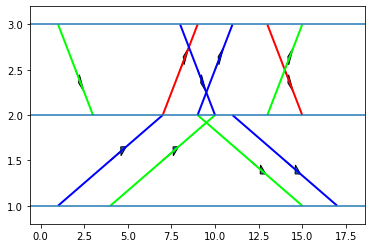

In [24]:
from matplotlib import collections  as mc
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np

findat=ff.replace('A',2).replace('B',3).replace('C',1)
finn=list(findat.loc[:,'fleet'])
lin=[]
av=[]
for i in range(len(findat)):
    p1=[int(findat.loc[i,'ts1']),int(findat.loc[i,'air1'])]
    p2=[int(findat.loc[i,'ts2']),int(findat.loc[i,'air2'])]
    av.append([np.mean(x) for x in zip(p1, p2)])
    lin.append([p1,p2])

c=[]
for i in range(len(lin)):
    if finn[i]=='f1':
        c.append([1, 0, 0, 1])
    elif finn[i]=='f2':
        c.append([0, 1, 0, 1])
    elif finn[i]=='f3':
        c.append([0, 0, 1, 1])
#c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
lc = mc.LineCollection(lin, colors=c,linewidths=2)

plt.figure()
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.axhline(y=1)
plt.axhline(y=2)
plt.axhline(y=3)
for i in range(len(av)):
    plt.arrow(av[i][0], av[i][1], (lin[i][1][0]-lin[i][0][0])/10, (lin[i][1][1]-lin[i][0][1])/10,head_width=0.1, head_length=0.31)

# Generating big data

<br>1)To generate flight data, we first generate a random number of airports.
<br>2)Next, we generate a random number of outgoing flights from all but one of the airports
<br>3)We use a GAMS code to balance the number of incoming and outgoing flights over all of the airports. This helps generate a valid dataset even with random values.
<br>4)We now generate random timing slots for flights from each airport while making sure none of the flights overlap.
<br>5)Finally, we generate fares and demands for all of the flights
<br>6)This data and randomly generated operational costs for all possible combinations of fleets and airports together make the data that we convert to Excel file formats(xlxs).
<br>7)We use the GDXXRW utility to convert these Excel files to gdx format.
<br>8)We then use this gdx data in our model for fleet scheduling

**We have documented all code and required steps in a separate notebook - appendix.ipynb for easier readability.**

We use the gdx files on our model. These need to be uploaded. They can be found in the folder along with the appendix notebook.

In [39]:
%gams_cleanup -k
%gams_reset

In [40]:
%%gams
set air/1*5/;
set ts/1*17/;
set fleet/1*5/;
alias(i,j,air);
alias(ts1, ts2, ts);
set nodes(air, ts);
alias(n1, n2, nodes);

set groundarcs(air, air, ts, ts);
groundarcs(i,j, ts1, ts2) = yes$(sameAs(i, j) and ord(ts2) = ord(ts1) + 1);
groundarcs(i, j, '17', '1') = yes$(sameAs(i, j));
display groundarcs;

$gdxin demand.gdx
parameter dem(air,air,ts,ts);
$load dem
$gdxin fares.gdx
parameter fare(air,air,ts,ts);
$load fare
$gdxin skarc.gdx
parameter skyarcs(air,air,ts,ts);
$load skyarcs
display dem,fare,skyarcs;
$gdxin opcos.gdx    

parameter cap(fleet)/1 120,2 150,3 250,4 200,5 100/;
parameter num(fleet) /1 4, 2 3, 3 2,4 1,5 2/;


parameter opcos(fleet,air,air);
$load opcos
display opcos;



binary variable f(fleet, air, air,ts, ts);
positive variable groundFlights(fleet, air, air, ts, ts);
parameter costs(fleet, air, air,ts, ts);
costs(fleet, i, j,ts1, ts2)$skyarcs(i, j,ts1, ts2) = fare(i, j, ts1, ts2)*min(dem(i,j, ts1, ts2), cap(fleet)) - opcos(fleet, i, j);
display costs;
*variable cost(fleet, air, ts, air, ts), min_value(fleet, air, ts, air, ts);
free variable obj;

equations objective, fleetAssignEq, groundFlightsEq, flowEq;
$ontext
minValue_eq1(fleet, i, ts1, j, ts2)$skyarcs(i, ts1, j, ts2)..
min_value(fleet, i, ts1, j, ts2) =l= dem(i, ts1, j, ts2);

minValue_eq2(fleet, i, ts1, j, ts2)$skyarcs(i, ts1, j, ts2)..
min_value(fleet, i, ts1, j, ts2) =l= cap(fleet);

assignCostEq(fleet, i, ts1, j, ts2)$skyarcs(i, ts1, j, ts2)..
cost(fleet, i, ts1, j, ts2) =e= fare(i, ts1, j, ts2)*min_value(fleet, i, ts1, j, ts2) - opcos(fleet, i, j)*1000;
$offtext

* The objective function maximizes the total attainable profit
objective..
obj =e= sum((fleet, i, ts1, j, ts2)$skyarcs(i, j, ts1, ts2), f(fleet, i, j,ts1, ts2)*costs(fleet, i,  j,ts1, ts2));

* This equation ensures we assign only one kind of fleet to any given flight
fleetAssignEq(i, j,ts1, ts2)$skyarcs(i, j,ts1, ts2)..
sum(fleet, f(fleet, i, j,ts1, ts2)) =e= 1;

* This equation ensures we are within the number of available fleets.
* For each fleet, time slot, the total of the sum of all groundflights and the sum of all assignments to flights must be less than the available number.
groundFlightsEq(fleet, ts1)..
sum((i, j, ts2)$groundarcs(i, j,ts1, ts2), groundFlights(fleet, i, j,ts1, ts2)) + sum((i, j, ts2)$skyarcs(i, j, ts1, ts2), f(fleet, i, j, ts1, ts2)) =l= num(fleet);

* This equation is for the flow balance. For each type of fleet, the total number of flights on the ground plust the incoming flights is equal to the total number of flights on the ground in the next time slot plus the total outgoing flights.
flowEq(fleet, i, ts1)..
sum(ts$groundarcs(i, i,ts, ts1), groundFlights(fleet, i, i,ts, ts1)) + sum((j, ts2)$skyarcs(j, i,ts2, ts1), f(fleet, j, i,ts2,ts1))=e= sum(ts$groundarcs(i, i,ts1, ts), groundFlights(fleet, i, i,ts1, ts)) + sum((j, ts2)$skyarcs(i,  j,ts1, ts2), f(fleet, i, j,ts1, ts2));

model final /all/;
solve final using mip max obj;
display f.l


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),3387.0,527,506,MIP,CPLEX,0.035


In [41]:
%gams_pull -d f
ff=f.loc[f['level']==1]
ff=ff.drop(columns=['marginal','lower','upper','level','scale']).reset_index().drop(['index'],axis=1)
ff.columns=['fleet', 'air1', 'air2', 'ts1', 'ts2']
display(ff)

,fleet,air1,air2,ts1,ts2
0,1,1,2,6,10
1,1,2,1,15,16
2,2,1,5,7,14
3,2,3,4,5,6
4,2,4,3,9,16
5,2,5,1,9,13
6,3,1,3,7,8
7,3,2,1,2,6
8,3,2,3,6,8
9,3,3,2,4,6


<Figure size 432x288 with 0 Axes>

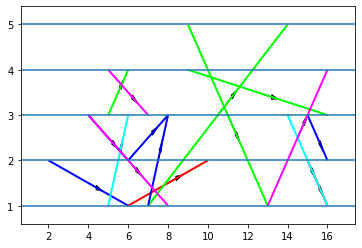

In [44]:
findat=ff
finn=list(findat.loc[:,'fleet'])
lin=[]
av=[]
for i in range(len(findat)):
    p1=[int(findat.loc[i,'ts1']),int(findat.loc[i,'air1'])]
    p2=[int(findat.loc[i,'ts2']),int(findat.loc[i,'air2'])]
    av.append([np.mean(x) for x in zip(p1, p2)])
    lin.append([p1,p2])

c=[]
for i in range(len(lin)):
    if finn[i]=='1':
        c.append([1, 0, 0, 1])
    elif finn[i]=='2':
        c.append([0, 1, 0, 1])
    elif finn[i]=='3':
        c.append([0, 0, 1, 1])
    elif finn[i]=='4':
        c.append([0, 1, 1, 1])
    elif finn[i]=='5':
        c.append([1, 0, 1, 1])
#c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
lc = mc.LineCollection(lin, colors=c,linewidths=2)

plt.figure()
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.axhline(y=1)
plt.axhline(y=2)
plt.axhline(y=3)
plt.axhline(y=4)
plt.axhline(y=5)

for i in range(len(av)):
    plt.arrow(av[i][0], av[i][1], (lin[i][1][0]-lin[i][0][0])/10, (lin[i][1][1]-lin[i][0][1])/10,head_width=0.1, head_length=0.31)

# Comments

As we can see, creating data with just 15 schedules instead of 10 increased the number of equations from 215 to 527. This increase is expected. For larger data, there are 1000s of such equations. This is a limitation of using a time space network.

## Extending this model

The assumption that there are only direct connections between airports is a naive one. For long distance flights, there maybe multiple connections until the destination. 

>Given there are direct as well as connecting flights, this means that a flight taken from A-B can have two different types of passengers in this flight:
* Passengers who are going from A-B
* Passengers who are going from X-Y but one connection on their way is from A-B

The fleet assignment problem now becomes to find the optimal assignment of the fleet and also the optimal number of passengers that need to travel from each itinerary. Along with the flight schedule, we will now have data for itineraries indicating each one’s price and demand.

In the previous examples, the flight schedule provided the itineraries as well. Now we need to split this data. Flight legs provide the connection between airports and the times of connections. The airlines has decided that there needs to be a flight connecting these two airports between these two times. Itineraries indicate the price and demand of passengers for each of the flight leg.

Let us work with a small example:

 
| Source    | Destination | Dep Time   | Arrival Time |
| :---       |:----:   |       :---: | ---:|
| A | B | 1 | 3 |
| B | C | 5 | 7 |
| C | A | 9 | 11 |

**Itineraries**

| Itinerary | Source    | Destination | Dep Time   | Arrival Time |
| :--- | :---:       |:----:   |       :---: | ---:|
| i1 | A | B | 1 | 3 |
| i2  | B | C | 5 | 7 |
| i3 | A | C | 1 | 7 |
| i4 | C | A | 9 | 11 |

| Itinerary | Fare    | Demand |
| :--- |      :---: | ---:|
| i1 | 200 | 75 |
| i2 | 225 | 150 |
| i3 | 300 | 75 |
| i4 | 400 | 50 |

 
| Fleet Type     | Number owned | Capacity     |
| :---       |:----:   |       --- |
| f1 | 1 | 100 |
| f2 | 1 | 200 |


| Fleet Type     | Airports | Operational Cost (000$) |
| ---       |----   |       --- |
| f1 | A-B | 10 |
| f1 | B-C | 20 |
| f1 | C-A | 15 |
| f2 | A-B | 20 |
| f2 | B-C | 39.5 |
| f2 | C-A | 30 |

# Model 2

Along with the all the variables equations of the previous model, we have a few more variables and equations in this model.
**Sets**:
* itinerary

**Variables**
* t$_{itinerary, airport, time, airport, time}$ - Indicates the number of people from each itinerary flying in a flight leg.
* k$_{itinerary}$ - Used for preserving itinerary. This means that if 30 people are assigned to fly in it3( A-C ) from A-B, exactly 30 must also fly from B-C since it3 has the start as A and end as C.

**Equations**

> **Itinerary Bound Equation** - The number of people assigned to each itinerary must be less than the demand.
$$t_{itinerary, airport, time, airport, time} \leq demand_{itinerary}$$

> **Flight Capacity Equation** - The total number of all people (from different itineraries) assigned to a flight must be less than the fleet capacity assigned to this flight.
$$\sum_{itinerary}t_{itinerary, airport, time, airport, time} \leq \sum_{fleet}f_{airport, time, airport, time}*capacity_{fleet}$$

> **Preserver Itinerary Equation** - If passengers were given to an itinerary then they must be flown entirely to the end. We cannot drop them midway!
$$t_{itinerary, airport, time, airport, time} = k_{itinerary}$$

# The Gams Model 2

In [29]:
%gams_cleanup -k
%gams_reset

In [30]:
%%gams
set airport/A,B,C/;
set time/1*17/;
set fleet/f1*f2/;
alias(i,j,airport);
alias(ts1, ts2, time);
* skyarcs is basically the flight connections, i.e which airport are connected for this airlines.
set skyarcs(airport, time, airport, time) /
(A.1).(B.3),
(B.5).(C.7),
(C.9).(A.11)
/;
set groundarcs(airport, time, airport, time);
groundarcs(i, ts1, j, ts2) = yes$(sameAs(i, j) and ord(ts2) = ord(ts1) + 1);
groundarcs(i, '17', j, '1') = yes$(sameAs(i, j));
display groundarcs;

* Itineraries give the demand and fare2. This is basically useful for connecting flights.
* The example here is such that there is a connecting flight through airport B. it3 gives this itinerary. The start is A and final destination is C.
set itinerary /i1*i4/;
set itarcs(itinerary, airport, time, airport, time)/
i1.(A.1).(B.3),
i2.(B.5).(C.7),
i3.(A.1).(B.3),
i3.(B.5).(C.7),
i4.(C.9).(A.11)
/;


parameter demand(itinerary)/i1 75, i2 150, i3 75, i4 50/;
parameter fare2(itinerary) /i1 200, i2 225, i3 300, i4 200/;
parameter cap2(fleet)/f1 100, f2 200/;
parameter num2(fleet) /f1 1, f2 1/;

* Operating costs to fly between airportports.
parameter opcos(fleet,airport,airport)/
    f1.A.B 10, f1.B.A 10, f1.B.C 20, f1.C.B 20, f1.C.A 15
    f2.A.B 20, f2.B.C 39.5, f2.B.A 20, f2.C.B 39.5, f2.C.A 30
/;
* costs parameter is the cost for assigning fleet to the flight
parameter costs(fleet, airport, time, airport, time);
costs(fleet, i, ts1, j, ts2)$skyarcs(i, ts1, j, ts2) = 1000*opcos(fleet, i, j);

In [31]:
%%gams
* f is used to determine which fleet should be assigned to which flight
binary variable f(fleet, airport, time, airport, time);
* groundFlights gives the num2ber of flights at the ground
positive variable groundFlights(fleet, airport, time, airport, time);
free variable obj;
alias(it1, it2, itinerary);

* t gives the num2ber of people flying in each itinerary.
positive variable t(it1, i, ts1, j, ts2);
* k is used to make sure that the people assigned to an itinerary are preserved.
* This means that if 30 people are assigned to fly in it3( A-C ) from A-B, exactly 30 must also fly from B-C since it3 has the start as A and end as C.
positive variable k(itinerary);

equations objective, fleetAssignEq, groundFlightsEq(fleet, ts1), flowEq, itineraryBoundEq, itinerarycapacityEq, preserveItineraryEq;

* The objective function maximizes the total attainable profit
objective..
obj =e= sum(itinerary, fare2(itinerary)*k(itinerary)) - sum((fleet, i, ts1, j, ts2)$skyarcs(i, ts1, j, ts2), f(fleet, i, ts1, j, ts2)*costs(fleet, i, ts1, j, ts2));

* This equation ensures we assign only one kind of fleet to any given flight
fleetAssignEq(i, ts1, j, ts2)$skyarcs(i, ts1, j, ts2)..
sum(fleet, f(fleet, i, ts1, j, ts2)) =e= 1;

* This equation ensures we are within the num2ber of available fleets.
* For each fleet, time slot, the total of the sum of all groundflights and the sum of all assignments to flights must be less than the available num2ber.
groundFlightsEq(fleet, ts1)..
sum((i, j, ts2)$groundarcs(i, ts1, j, ts2), groundFlights(fleet, i, ts1, j, ts2)) + sum((i, j, ts2)$skyarcs(i, ts1, j, ts2), f(fleet, i, ts1, j, ts2)) =l= num2(fleet);

* This equation is for the flow balance. For each type of fleet, the total num2ber of flights on the ground plust the incoming flights is equal to the total num2ber of flights on the ground in the next time slot plus the total outgoing flights.
flowEq(fleet, i, ts1)..
sum(time$groundarcs(i, time, i, ts1), groundFlights(fleet, i, time, i, ts1)) + sum((j, ts2)$skyarcs(j, ts2, i, ts1), f(fleet, j, ts2, i, ts1)) =e= sum(time$groundarcs(i, ts1, i, time), groundFlights(fleet, i, ts1, i, time)) + sum((j, ts2)$skyarcs(i, ts1, j, ts2), f(fleet, i, ts1, j, ts2));

* The num2ber of people assigned to each itinerary must be less than the demand.
itineraryBoundEq(itinerary, i, ts1, j, ts2)$itarcs(itinerary, i, ts1, j, ts2)..
t(itinerary, i, ts1, j, ts2) =l= demand(itinerary);

* The total num2ber of all people (from different itineraries) assigned to a flight must be less than the fleet cap2acity assigned to this flight.
itinerarycapacityEq(i, ts1, j, ts2)$skyarcs(i, ts1, j, ts2)..
sum(itinerary$itarcs(itinerary, i, ts1, j, ts2), t(itinerary, i, ts1, j, ts2)) =l= sum(fleet, f(fleet, i, ts1, j, ts2)*cap2(fleet));

* If passengers were given to an itinerary then they must be flown entirely to the end. Cannot drop midwaaay....
preserveItineraryEq(itinerary, i, ts1, j, ts2)$itarcs(itinerary, i, ts1, j, ts2)..
t(itinerary, i, ts1, j, ts2) =e= k(itinerary);

model final /all/;
solve final using mip max obj;
display f.l, t.l;
display k.l;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),4375.0,153,118,MIP,CPLEX,0.026


In [32]:
%gams_pull -d f k
display(k)
ff=f.loc[f['level']==1]
ff=ff.drop(columns=['marginal','lower','upper','level','scale']).reset_index().drop(['index'],axis=1)
ff.columns=['fleet', 'air1', 'ts1', 'air2', 'ts2']
display(ff)

,itinerary,level,marginal,lower,upper,scale
0,i1,75.0,0.0,0.0,inf,1.0
1,i2,75.0,0.0,0.0,inf,1.0
2,i3,25.0,0.0,0.0,inf,1.0
3,i4,50.0,0.0,0.0,inf,1.0


,fleet,air1,ts1,air2,ts2
0,f1,A,1,B,3
1,f1,B,5,C,7
2,f1,C,9,A,11


<span style="color:blue">This indicates that there were 75 passengers from itinerary 1 and 25 passengers from itinerary 2 who flew from A-B on the same aircraft (f1).</span>

Adding connecting flights definitely increases the complexity of the problem.

Generating larger data for this extended model proved to be more tricky and we ran out of time while figuring this out. But similar to the previous model we expect the number of equations to grow rapidly and it would take quite a while to solve real world use cases involving 100s of airports and numerous schedules. 

# Conclusion

In this project we have modeled a fleet assignment problem. The main objective of this problem is to maximize profits for the airlines by choosing the correct assignment of fleet to flight legs. We assume a repeated cycle of 24-hour periods along with several other assumptions. We have explained the model mathematically and solved it using GAMS. We further explain on how to generate larger data and show that the size of the model grows rapidly as we increase the number of flight schedules. We extend this model to include connecting flights and solve this new model on top of the exisiting model by introducing new variables and equations.

## References used

* GAMS User Guide, which is available [here:](https://www.gams.com/latest/docs/UG_MAIN.html#UG_Tutorial_Examples)
* Subramanian, Radhika et al. “Coldstart: Fleet Assignment at Delta Air Lines.” (1994).
* PPT [here:](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=2ahUKEwjFvJ-TqMHmAhUFXc0KHV1RArIQFjABegQIAxAC&url=https%3A%2F%2Fcatsr.vse.gmu.edu%2FSYST660%2FVideo_Airline_Schedule_Optimization_(Fleet_Assignment_II).pptx&usg=AOvVaw1EbcWiaE8vw4oXYGyeTH1m)